
# DATA301 - Lab 0
## Dask Tutorial (first part)

In this tutorial, you will learn how to use [Dask](https://www.dask.org/) in a notebook enviroment.

Adapted with permission for use in DATA301. Additional credits to [Tiziano Piccardi](http://piccardi.me/) from his Applied Data Analysis class at EPFL and [Michele Catasta](https://www.linkedin.com/in/pirroh/) from Stanford's CS246.

*Note: do not change the existing asserts otherwise you will not know if your code works for our tests. You are welcome to add your own asserts in new cells.*

## Setup

The online Colab environment already has the Dask library installed but we'll just make sure, so we ask pip to install the dask library on colab.

In [2]:
!pip install dask

In [3]:
import urllib.request
url = 'https://drive.google.com/uc?export=download&confirm=t&id=1QXSn0Y7YHNY1P2ag4SPeYuCOPoJVtjzO'
filename = 'Bombing_Operations.parquet'
urllib.request.urlretrieve(url, filename)

('Bombing_Operations.parquet', <http.client.HTTPMessage at 0x7c39f8641300>)

## Warm up exercises (complete the <FILL IN> parts)
These exercises don't use a dataset. Instead they create simple Dask array structures.

Let us first create a small array that we will manipulate. For realistic applications, data will most likely be loaded from a file, from a data stream, or generated with special Dask functions. We are transitioning from Python though, so we will show how this can be done.


In [4]:
#import the dask and bag library
import dask
import dask.bag as db
import math

# First, let's create some simple data, say the integers from 1 to 1000.
# We use the python command range to do this.
# Note that in practice our data will most likely come from data files.
A = range(1000)

# Let us start with a simple task of computing the sum of the values in the array:
print(sum(A))
# Because A is in memory in our Google Colab python instance and sum is a built in python function
# this computation is not distributed and instead runs sequentially.

# Now let us distribute this data across our processes in a dask bag
bA = db.from_sequence(A)

# To sum our distributed array, we call the reduce function with the sum function
print(bA.reduction(sum, sum).compute())
# Because the data structure bA was distributed across the available processes, the computation for reduction was also distributed.

# Because summing along an array axis is very common, we could simply call the built-in function that does the reduction efficiently
print(bA.sum().compute())



499500
499500
499500


###Problem 1 (5 points)
Now that we have seen a simple example, write **sequential** code that implements the example from the lecture

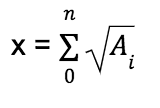

In [5]:
def sum_sqrts(A):
    sum = A[0] ** 0.5
    for i in range(1, len(A)):
      sum += A[i] ** 0.5
    return sum

In [6]:
assert sum_sqrts([1,4,9,16]) == 10

### Problem 2 (5 points)
Now write a *parallel* version of the code using Dask. You will need to use both map and reduction functions (see https://docs.dask.org/en/stable/bag-api.html).


In [7]:
#note: bA is assumed to be a dask bag already, see test case
def sum_sqrts_parallel(bA):
    sqrt = bA.map(lambda x: x ** 0.5)
    return sqrt.reduction(sum, sum).compute()



print(sum_sqrts_parallel(db.from_sequence([1,4,9,16])))

10.0


In [8]:
assert sum_sqrts_parallel(db.from_sequence([1,4,9,16])) == 10

### Problem 3 (10 points)

In [9]:
# Let us quickly review some basic transformations available within Dask.

# Lets create a small list of numbers to play with.
nums = db.from_sequence([1,2,3,4,5])

# retain elements passing a predicate
# this is a lambda expression -- often used to be more concise than a full function declaration
evens = nums.filter(lambda x: x % 2 == 0)
# (this is equivalent to the lambda expression but uses a named function)
def is_even(x):
  return x % 2 == 0
evens = nums.filter(is_even)

# map each element
num_ranges = nums.map(lambda x: list(range(x)))

# retrieve bag contents as a local collection - in this case a list of lists
print(num_ranges.compute())

# flatten
num_ranges_flat = num_ranges.flatten()

print(num_ranges_flat)

# return first 3 elements, note that this only gives back 1 (and a warning)!
print(num_ranges_flat.take(3))

# count number of elements
print(num_ranges_flat.count().compute())

# what happened? the elements are split into partitions and take only looks at
#  one partition by default. Because our data originally was 5 nested lists,
#  we have 5 partitions with the data from each list in each partition.

# to take the first 3 from all partitions:
print(num_ranges_flat.take(3, npartitions=-1))

# or we could repartition (but that is more expensive as it moves some things in memory)
num_ranges_flat_one_partition = num_ranges_flat.repartition(1)
print(num_ranges_flat_one_partition)
print(num_ranges_flat_one_partition.take(3))
print(num_ranges_flat_one_partition.count().compute())



[[0], [0, 1], [0, 1, 2], [0, 1, 2, 3], [0, 1, 2, 3, 4]]
dask.bag<flatten, npartitions=5>
(0,)
15
(0, 0, 1)
dask.bag<repartition, npartitions=1>
(0, 0, 1)
15


In the code box below. Write a function that consumes a bag of numeric values and produces a bag with that many copies of each value.

**note:** your function should not convert the bag to a local data structure such as a Python list -- you need to use map/reduction/flatten.

Some test cases:
```
print(list(repeat_nums(db.from_sequence([1, 3, 4, 2, 1]))))
> [1, 3, 3, 3, 4, 4, 4, 4, 2, 2, 1]

print(list(repeat_nums(db.from_sequence([5, 2, 6, 3, 1]))))
> [5, 5, 5, 5, 5, 2, 2, 6, 6, 6, 6, 6, 6, 3, 3, 3, 1]
```
Hint: In python we can repeat using the overloaded multiplier on lists

```
>>> [5] * 4
[5, 5, 5, 5]
```




In [10]:
def repeat_nums(b_nums):
    return b_nums.map(lambda x: db.from_sequence([x] * x)).flatten()


In [11]:
print(list(repeat_nums(db.from_sequence([1, 3, 4, 2, 1]))))
print(list(repeat_nums(db.from_sequence([5, 2, 6, 3, 1]))))

[1, 3, 3, 3, 4, 4, 4, 4, 2, 2, 1]
[5, 5, 5, 5, 5, 2, 2, 6, 6, 6, 6, 6, 6, 3, 3, 3, 1]


In [12]:
assert list(repeat_nums(db.from_sequence([1, 3, 4, 2, 1]))) == [1, 3, 3, 3, 4, 4, 4, 4, 2, 2, 1]
assert list(repeat_nums(db.from_sequence([5, 2, 6, 3, 1]))) == [5, 5, 5, 5, 5, 2, 2, 6, 6, 6, 6, 6, 6, 3, 3, 3, 1]

## Dataset exercises: The Vietnam War

For the following exercises you will write parallel code in PySpark to extract some data from a small dataset of historical data from the Vietname War.

**Pres. Johnson**: _What do you think about this Vietnam thing? I’d like to hear you talk a little bit._

**Sen. Russell**: _Well, frankly, Mr. President, it’s the damn worse mess that I ever saw, and I don’t like to brag and I never have been right many times in my life, but I knew that we were going to get into this sort of mess when we went in there._

May 27, 1964

![banner](https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/banner.jpg)

----

The Vietnam War, also known as the Second Indochina War, and in Vietnam as the Resistance War Against America or simply the American War, was a conflict that occurred in Vietnam, Laos, and Cambodia from 1 November 1955 to the fall of Saigon on 30 April 1975. It was the second of the Indochina Wars and was officially fought between North Vietnam and the government of South Vietnam.

**The dataset describes all the air force operations during the Vietnam War.**

**Bombing_Operations**

- AirCraft: _Aircraft model (example: EC-47)_
- ContryFlyingMission: _Country_
- MissionDate: _Date of the mission_
- OperationSupported: _Supported War operation_ (example: [Operation Rolling Thunder](https://en.wikipedia.org/wiki/Operation_Rolling_Thunder))
- PeriodOfDay: _Day or night_
- TakeoffLocation: _Take off airport_
- TimeOnTarget
- WeaponType
- WeaponsLoadedWeight

**Dataset Information:**

THOR is a painstakingly cultivated database of historic aerial bombings from World War I through Vietnam. It has 4,400,775 records. THOR has already proven useful in finding unexploded ordnance in Southeast Asia and improving Air Force combat tactics:
https://www.kaggle.com/usaf/vietnam-war-bombing-operations

If it didn't download earlier, you can manually [Get the dataset here](https://drive.google.com/file/d/1QXSn0Y7YHNY1P2ag4SPeYuCOPoJVtjzO/view?usp=drive_link). Just make sure to upload it to Colab.

###*Load the dataset*
If you get an error, make sure your upload/download of the Bombing_Operations.parquet file has finished.

In [13]:
import dask.dataframe as df

Bombing_Operations_df = df.read_parquet('Bombing_Operations.parquet')
Bombing_Operations = Bombing_Operations_df.to_bag().persist()
column_indices = dict([(k, i) for i, k in enumerate(Bombing_Operations_df.columns)])
print(column_indices)

{'ContryFlyingMission': 0, 'MissionDate': 1, 'AirCraft': 2, 'TakeoffLocation': 3, 'TimeOnTarget': 4, 'PeriodOfDay': 5, 'TargetCountry': 6, 'WeaponsLoadedWeight': 7, 'WeaponType': 8, 'OperationSupported': 9}


In [14]:
take_1 = Bombing_Operations.take(1)
print(take_1)

(('UNITED STATES OF AMERICA', '1971-06-05', 'EC-47', 'TAN SON NHUT', 1005.0, 'D', 'CAMBODIA', 0, None, None),)


Note that take(1) returns a list of size 1 where the one record is itself a tuple with values at inidices. We've extracted a mapping of the key and indices called column_indices and can access a column from a record with a simple lookup.

Here is a simple example:



In [15]:
record = take_1[0]
record[column_indices['AirCraft']]

'EC-47'

In [16]:
Bombing_Operations.count().compute()

4400775

### Problem 4 (10 points): How many missions did the UNITED STATES OF AMERICA fly?

In each of these problems you will need to use bag transformations and actions. You do not need to write full python functions, a lambda expression in each of the <FILL IN> blanks is sufficient. See https://docs.dask.org/en/stable/bag-api.html for a list of available bag transformations and actions and what they expect.

From the Bombing_Operations count how many rows have ContryFlyingMission with the UNITED STATES OF AMERICA

In [17]:
data_filtered = Bombing_Operations.filter(
    lambda row: row[column_indices['ContryFlyingMission']] == 'UNITED STATES OF AMERICA'
    )
print(data_filtered.count().compute())
# should output 3708997

3708997


In [18]:
assert data_filtered.count().compute() == 3708997

### Problem 5 (15 points): Show the unique countries targetted in missions on 1972-12-26

In [19]:
dec26 = Bombing_Operations.filter(
    lambda row: row[column_indices['MissionDate']] == '1972-12-26'
    )
target_countries = dec26.map(
    lambda x: x[column_indices['TargetCountry']]
    )
print(target_countries.distinct().compute())
# should output ['SOUTH VIETNAM', 'NORTH VIETNAM', 'LAOS', 'CAMBODIA', 'THAILAND']


['SOUTH VIETNAM', 'NORTH VIETNAM', 'LAOS', 'CAMBODIA', 'THAILAND']


In [20]:
assert target_countries.distinct().compute() == ['SOUTH VIETNAM', 'NORTH VIETNAM', 'LAOS', 'CAMBODIA', 'THAILAND']

### Problem 6 (15 points): Who bombed this location?


<img style="float: right;" src="https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/Hanoi_POL1966.jpg">

This picture is the Hanoi POL facility (North Vietnam) burning after it was attacked by the U.S. Air Force on 29 June 1966 in the context of the Rolling Thunder operation.

Write two lambda expressions that will help us discover what was the most common take-off location during that day of missions flown by the US (ContryFlyingMission) under OperationSupported of ROLLING THUN.

In [21]:
jun_29_operations = Bombing_Operations.filter(
    lambda row: row[column_indices['MissionDate']] == '1966-06-29'
    and row[column_indices['ContryFlyingMission']] == 'UNITED STATES OF AMERICA'
    and row[column_indices['OperationSupported']] == 'ROLLING THUN'
    )
by_takeofflocation = jun_29_operations.foldby(
    key = lambda row: row[column_indices['TakeoffLocation']],
    binop = lambda total, x: total + 1,
    initial = 0
    )
print(by_takeofflocation.compute())

# should produce a (key, value) list of take-off locations including ('CONSTELLATION', 83)

[('DANANG', 23), ('CONSTELLATION', 83), ('UBON AB', 44), ('UDORN AB', 10), ('KORAT', 31), ('TAKHLI', 41), ('RANGER', 33), ('HANCOCK (CVA-19)', 10), ('CUBI PT', 1)]


In [22]:
jun_29_operations.count().compute()

276

In [23]:
assert ('CONSTELLATION', 83) in by_takeofflocation.compute()

<img style="float: right;" src="https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/USS_Constellation.jpg">


That day the most common take-off location was the ship USS Constellation (CV-64). We cannot univocally identify one take off location, but we can reduce the possible candidates.

_USS Constellation (CV-64), a Kitty Hawk-class supercarrier, was the third ship of the United States Navy to be named in honor of the "new constellation of stars" on the flag of the United States. One of the fastest ships in the Navy, as proven by her victory during a battlegroup race held in 1985, she was nicknamed "Connie" by her crew and officially as "America's Flagship"._

### Problem 7 (15 points): What is the most used aircraft during the Vietnam war (number of missions)?

In this question you must write your own code "from scratch". Hint: if you follow a similar process to problem 6 you can get tuples of the form (aircraft, count). The max function can be used on a tuple but will compare tuples by their elements left to right so you need to be a little creative :).

In [40]:
aircraft_counts = Bombing_Operations.foldby(
    key = lambda row: row[column_indices['AirCraft']],
    binop = lambda total, x: total + 1,
    initial = 0
    )

most_used = aircraft_counts.map(lambda x: (x[1], x[0])).max()

print(most_used.compute())

# should compute (909362, 'F-4') as the result and assign it to the most_used variable

(909362, 'F-4')


In [42]:
assert most_used == (909362, 'F-4')

AssertionError: 

## Submission
You need to complete the quiz on the quiz server (https://quiz2024.csse.canterbury.ac.nz/mod/quiz/view.php?id=1961).